__Import library yang dibutuhkan__

In [66]:
import pandas as pd

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

from sklearn import tree
from sklearn import datasets

import mysql.connector
import sqlite3

import numpy.matlib 
import numpy as np 

__Load data__

In [67]:
db = mysql.connector.connect(
    host="localhost",
    user="root",
    password="",
    database="kelulusan"
)

query_select = db.cursor()
query_select.execute('SELECT npm, nm_mhs, angkatan, nm_matkul, nilai, semester, status FROM test UNION SELECT npm, nm_mhs, angkatan, nm_matkul, nilai, semester, status FROM train')
hasil_query_select = query_select.fetchall()

data = pd.DataFrame(hasil_query_select, columns=['NPM', 'Nama Mahasiswa', 'Angkatan', 'Matakuliah', 'Nilai', 'Semester', 'Status'])
# data

__Melakukan pivot pada data__

In [68]:
data_pivot = pd.pivot_table(data, values='Nilai', index='NPM', columns='Matakuliah')
data_pivot = data_pivot.merge(data[['NPM','Status']].drop_duplicates(),left_on='NPM',right_on='NPM')
data_pivot = data_pivot.fillna(-1) # mengganti nilai nan menjadi -1
# data_pivot

__Mengambil prediktor (X) dan target (y) dan mengubah status dari tiap mahasiswa, sehingga hanya ada 'Lulus' dan 'Terlambat'__

In [69]:
X = data_pivot.drop(['NPM','Status'],axis=1)
y = data_pivot['Status']
y.loc[y=='TERLAMBAT'] = 'Terlambat'
y.loc[y=='Tidak Lulus'] = 'Terlambat'
y.loc[y=='LULUS'] = 'Lulus'

c:\users\bsi\appdata\local\programs\python\python38-32\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


__Lakukan split training dan testing__

In [70]:
X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                    test_size=0.2,
                                                    random_state=42)

__Lakukan training dan testing__

In [71]:
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)
print(classification_report(y_test,clf.predict(X_test)))

              precision    recall  f1-score   support

       Lulus       1.00      1.00      1.00        34
   Terlambat       1.00      1.00      1.00        20

    accuracy                           1.00        54
   macro avg       1.00      1.00      1.00        54
weighted avg       1.00      1.00      1.00        54



__Visualisasikan ke dalam tree. Load library yang dibutuhkan__

In [72]:
from IPython.display import Image
from sklearn.tree import export_graphviz
import pydotplus

export_graphviz(clf, 'tree.dot', feature_names = X.columns)

__Simpan tree ke dalam file__

In [73]:
from graphviz import Digraph
!dot -Tpng tree.dot -o tree.png

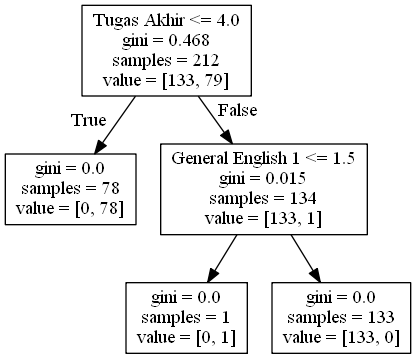

In [74]:
from graphviz import Graph
Image("tree.png")

__Rekomendasi semester mata kuliah dengan KNN__

__Gunakan data tanpa semester sebagai test, dan sisanya sebagai train__

In [75]:
data = data.replace('',np.nan, regex=True)
train = data[pd.notnull(data.Semester)][['Matakuliah','Semester']]
test = data[pd.isnull(data.Semester)][['Matakuliah','Semester']]
test

Matakuliah Semester
0                          Agama      NaN
1             Pengantar Logistik      NaN
2              General English 1      NaN
3             Matematika Diskrit      NaN
4      Algoritma & Struktur Data      NaN
...                          ...      ...
13255           Desain Interaksi      NaN
13256          Komunikasi Bisnis      NaN
13257               Internship I      NaN
13258              Internship II      NaN
13259                Tugas Akhir      NaN

[8900 rows x 2 columns]

__Load library dan ambil classifier__

In [76]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
rec = KNeighborsClassifier()
le = LabelEncoder()

__Definisikan data yang akan digunakan untuk training dan testing__

In [77]:
le.fit(train['Matakuliah'])
# le.fit(data['Matakuliah'])
X_train = le.transform(train['Matakuliah'])
X_test = le.transform(test['Matakuliah'])
y_train = train['Semester']
y_test = test['Semester']

__Lakukan training__

In [78]:
X_train = X_train.reshape(len(X_train),1)
X_test = X_test.reshape(len(X_test),1)
rec.fit(X_train,y_train)

KNeighborsClassifier()

__Lakukan prediksi (rekomendasi)__

In [80]:
test['Semester'] = rec.predict(X_test)
test

Matakuliah Semester
0                          Agama     Satu
1             Pengantar Logistik     Satu
2              General English 1     Satu
3             Matematika Diskrit     Satu
4      Algoritma & Struktur Data     Satu
...                          ...      ...
13255           Desain Interaksi     Enam
13256          Komunikasi Bisnis     Enam
13257               Internship I    Tujuh
13258              Internship II  Delapan
13259                Tugas Akhir  Delapan

[8900 rows x 2 columns]

Perlu dicatat bahwa tidak dapat dilakukan pengujian pada data test karena label semester pada data test yang sebenarnya tidak ada

In [81]:
 rec.fit(X_train, y_train)
 print(classification_report(y_test,rec.predict(X_test)))

              precision    recall  f1-score   support

     Delapan       1.00      1.00      1.00       356
         Dua       1.00      1.00      1.00      1068
       Empat       1.00      1.00      1.00      1780
        Enam       1.00      1.00      1.00      1424
        Lima       1.00      1.00      1.00      1246
        Satu       1.00      1.00      1.00      1424
        Tiga       1.00      1.00      1.00      1424
       Tujuh       1.00      1.00      1.00       178

    accuracy                           1.00      8900
   macro avg       1.00      1.00      1.00      8900
weighted avg       1.00      1.00      1.00      8900

